In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/'
output_folder = './output_data/'

In [4]:
import scanpy as sc

dataset_name = 'scGLUE'
dataset_color = 'yellow'
modality_names = ['RNA', 'ATAC']
data_folder = '../data/scGLUE/'

data1 = sc.read_h5ad(data_folder + 'Chen-2019-RNA.h5ad')
type1 = data1.obs.cell_type.to_numpy()
fname1 = data1.var.name.to_numpy()
data1 = data1.X.todense()

data2 = sc.read_h5ad(data_folder + 'Chen-2019-ATAC.h5ad')
type2 = data2.obs.cell_type.to_numpy()
fname2 = data2.var.index.to_numpy()
data2 = data2.X.todense()

# Labels
labels = [type1, type2]
features = [fname1, fname2]
feature_dict = {}

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\sklearn\preprocessing\_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\sklearn\preprocessing\_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 a

In [6]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
    # 'loss_weights': [1,1,1,0],
    # 'use_f_tilde': False,
    'dropout': 0,
    'enable_memory_logging': True,
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [7]:
integrated_data = []
integrated_names = []
colors = []
shapes = []

# JAMIE

In [8]:
# Integration
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

Loaded model './saved_models/jm---scGLUE---9190-28930---9190-241757---dropout-0.h5'


In [9]:
# Integration (.75)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_75---'
match_prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = match_prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_75 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_75.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_75_data = jm_75.fit_transform(dataset=dataset, P=tq_priors)
    jm_75.save_model(model_str)
    np.save(match_str, jm_75.match_result, allow_pickle=True)
jm_75_data = jm_75.transform(dataset=dataset)
integrated_data.append(jm_75_data)
integrated_names.append( 'JAMIE (.75)')
colors.append('lawngreen')
shapes.append('^')

Loaded model './saved_models/jm_75---scGLUE---9190-28930---9190-241757---dropout-0.h5'


In [10]:
# Integration (.5)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_50---'
match_prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = match_prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_50 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_50.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_50_data = jm_50.fit_transform(dataset=dataset, P=half_priors)
    jm_50.save_model(model_str)
    np.save(match_str, jm_50.match_result, allow_pickle=True)
jm_50_data = jm_50.transform(dataset=dataset)
integrated_data.append(jm_50_data)
integrated_names.append( 'JAMIE (.5)')
colors.append('midnightblue')
shapes.append('d')

Loaded model './saved_models/jm_50---scGLUE---9190-28930---9190-241757---dropout-0.h5'


In [11]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
match_prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = match_prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

Loaded model './saved_models/jm_im---scGLUE---9190-28930---9190-241757.h5'


# Comparison Methods

In [12]:
from sklearn.decomposition import PCA

# PCA features for algs that need it (To Revise)
max_feat = 10000
dataset_mini = dataset.copy()
pca_mini = []
for i in range(len(dataset_mini)):
    if dataset[i].shape[1] > max_feat:
        n_components = min(max_feat, dataset[i].shape[0])
        pca = PCA(n_components=n_components)
        # dataset_mini[i] = pca.fit_transform(dataset[i])
        dataset_mini[i] = np.zeros((dataset[i].shape[0], n_components))
        pca_mini.append(pca)

In [13]:
method_name, method_color, method_shape = 'NLMA', 'red', 'X'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _ = mmd_combine(*in_data, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data './output_data/NLMA---scGLUE---9190-28930---9190-241757.npy'


In [14]:
# CRASHES
# method_name, method_color, method_shape = 'LMA', 'orange', '*'
# in_data = dataset_mini
# method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
# method_str = output_folder + method_str + '.npy'
# try:
#     data = np.load(method_str)
#     print(f'Loaded data \'{method_str}\'')
# except FileNotFoundError:
#     data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
#     np.save(method_str, data)
# integrated_data.append(data)
# integrated_names.append(method_name)
# colors.append(method_color)
# shapes.append(method_shape)

In [15]:
# COLLAPSES
# method_name, method_color, method_shape = 'CCA', 'm', 'D'
# in_data = dataset_mini
# method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
# method_str = output_folder + method_str + '.npy'
# try:
#     data = np.load(method_str)
#     print(f'Loaded data \'{method_str}\'')
# except FileNotFoundError:
#     data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
#     np.save(method_str, data)
# integrated_data.append(data)
# integrated_names.append(method_name)
# colors.append(method_color)
# shapes.append(method_shape)

In [16]:
# CRASHES
# method_name, method_color, method_shape = 'MMD-MA', 'cyan', 'P'
# in_data = dataset
# in_data = [d / np.linalg.norm(d, axis=1).reshape(-1, 1) for d in in_data]
# in_data = [np.matmul(d, d.T) for d in in_data]
# method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
# method_str = output_folder + method_str + '.npy'
# try:
#     data = np.load(method_str)
#     print(f'Loaded data \'{method_str}\'')
# except FileNotFoundError:
#     data, _, _ = mmd_combine(*in_data, method='mmd_ma', p=reduced_dim, max_iterations=10001)
#     np.save(method_str, data)
# integrated_data.append(data)
# integrated_names.append(method_name)
# colors.append(method_color)
# shapes.append(method_shape)

In [17]:
# CRASHES
# method_name, method_color, method_shape = 'UnionCom', 'green', 's'
# in_data = dataset
# method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
# method_str = output_folder + method_str + '.npy'
# try:
#     data = np.load(method_str)
#     print(f'Loaded data \'{method_str}\'')
# except FileNotFoundError:
#     data, _, _ = mmd_combine(*in_data, method='unioncom', output_dim=reduced_dim)
#     np.save(method_str, data)
# integrated_data.append(data)
# integrated_names.append(method_name)
# colors.append(method_color)
# shapes.append(method_shape)

In [18]:
method_name, method_color, method_shape = 'scGLUE', 'yellow', 'p'
in_data = dataset
data =[
    np.load(data_folder + 'embedded/rna_embedded.npy'),
    np.load(data_folder + 'embedded/atac_embedded.npy')]
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [19]:
# # Imputation
# if False:
#     imputation_name = 'Babel'
# else:
#     imputation_name = 'KNN'
#     nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float(), manual=True) for i in range(1, -1, -1)]
# imputed_data_full = [jm_imputed, nn_imputed][::-1]
# imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
# imputed_names = ['JAMIE', imputation_name][::-1]

# No baseline
nn_imputed = imputation_name = None
imputed_data_full = [jm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] if ds is not None else None for ds in imputed_data_full]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [20]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'svg.fonttype': 'none',
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})
sns.set_palette('husl', len(np.unique(labels)))

In [21]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-LabelLegend.svg', bbox_inches=bbox, format='svg')

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.svg', bbox_inches=bbox, format='svg')

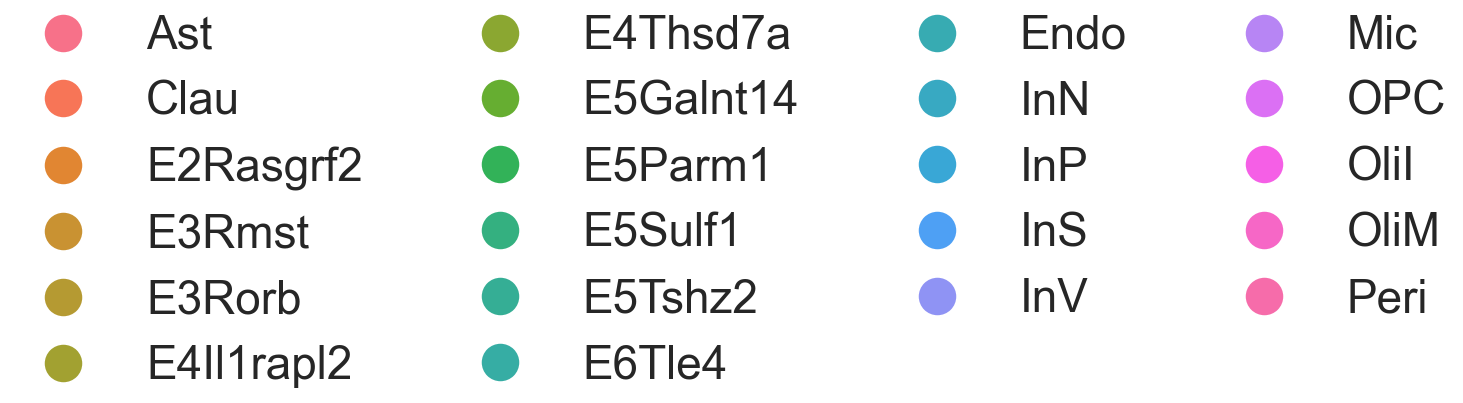

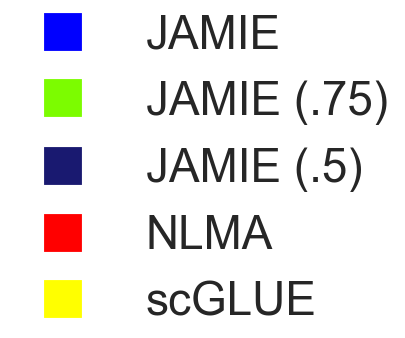

In [22]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=100) )

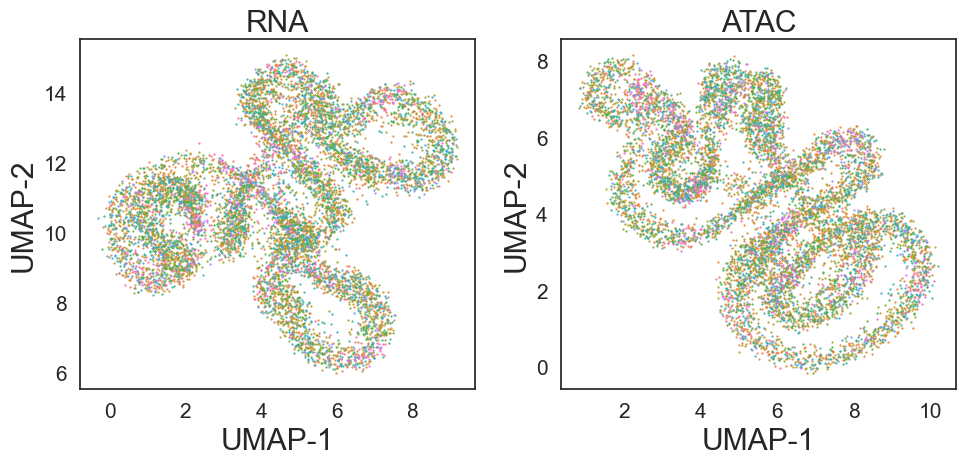

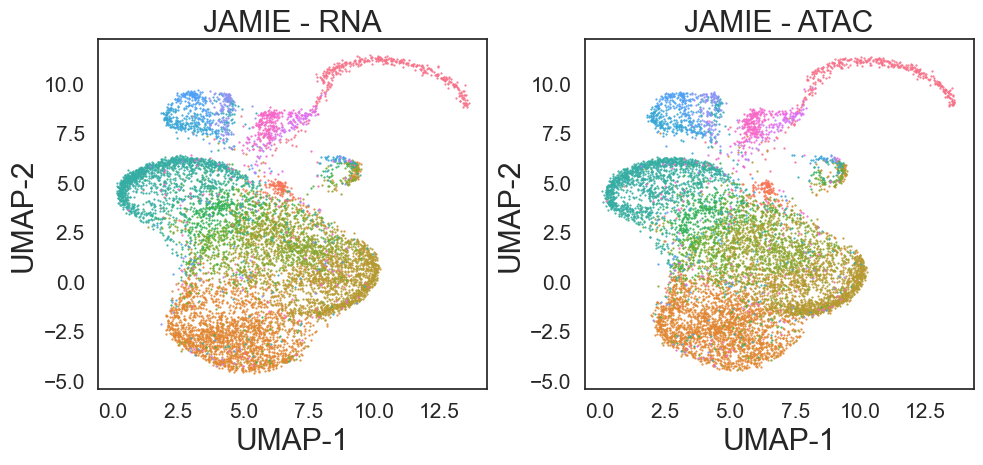

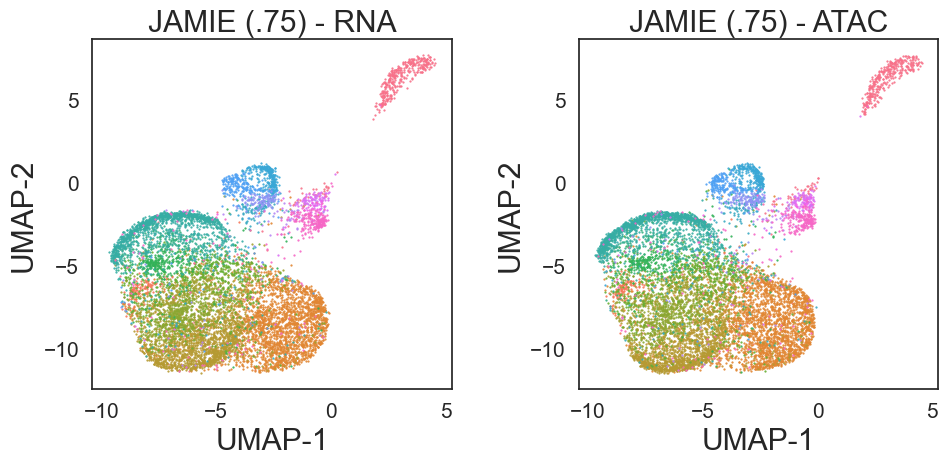

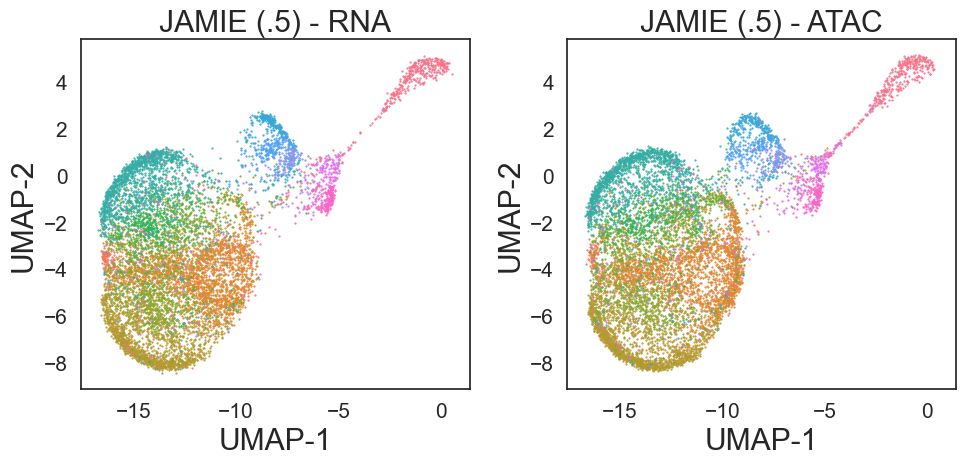

c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


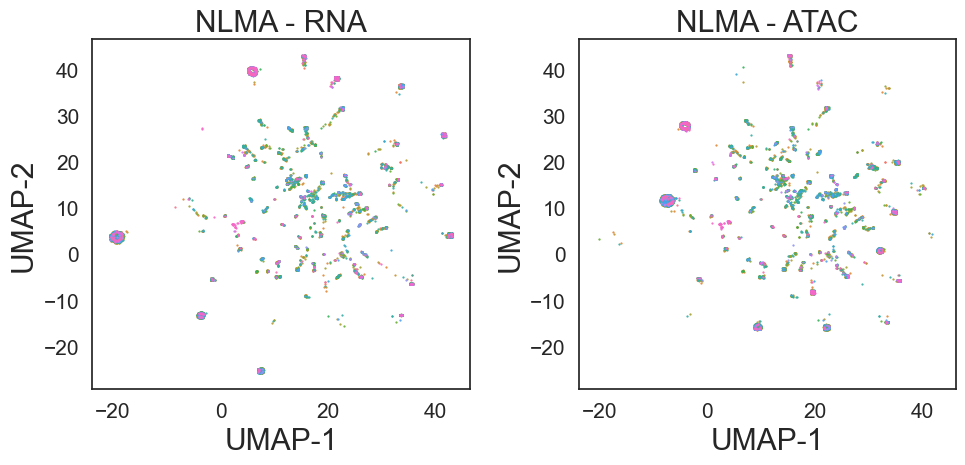

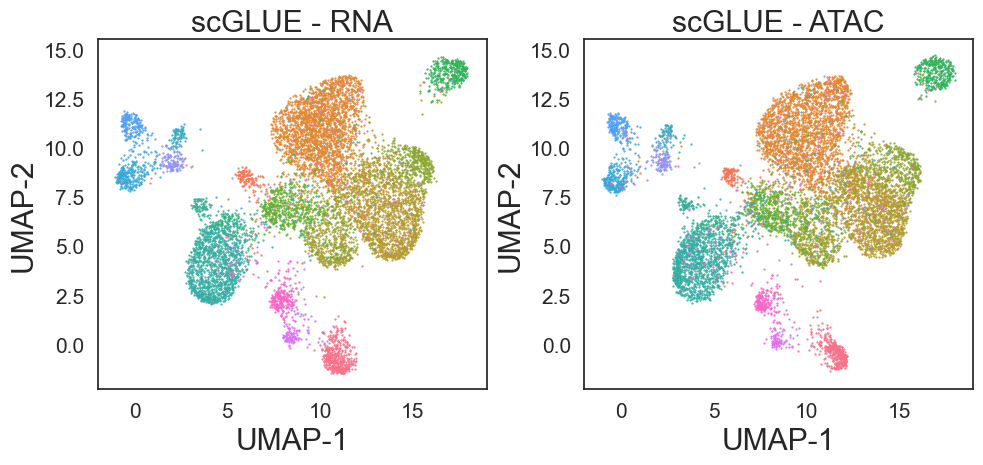

In [23]:
# Raw data
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Data.svg', format='svg', bbox_inches='tight')

# Integrated data
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.savefig(image_folder + dataset_name + f'-{n}.svg', format='svg', bbox_inches='tight')
    plt.show()

Algorithm     JAMIE      NLMA    scGLUE
FOSCTTM    0.000522  0.035058  0.037542
LTA        0.858651  0.259412  0.854407
Algorithm     JAMIE  JAMIE (.75)  JAMIE (.5)      NLMA    scGLUE
FOSCTTM    0.000522     0.056229    0.122760  0.035058  0.037542
LTA        0.858651     0.822742    0.788248  0.259412  0.854407


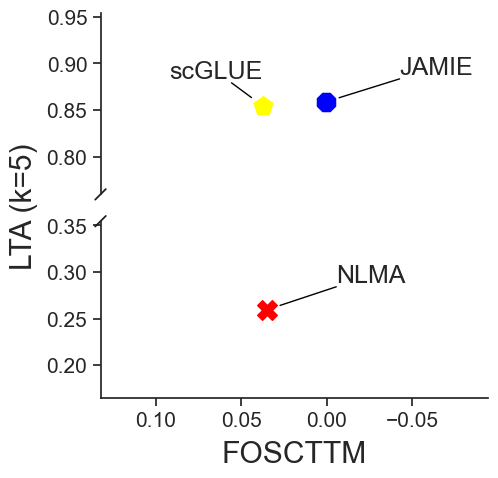

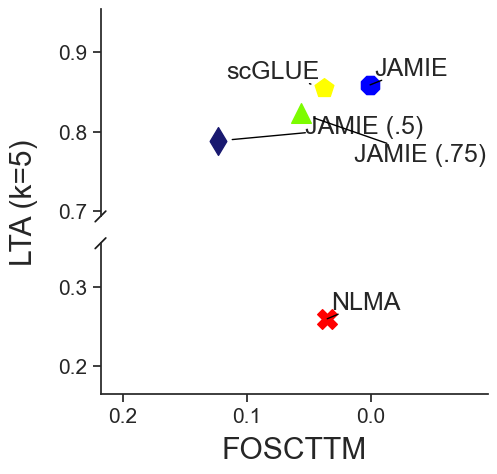

In [24]:
with_idx = [i for i in range(len(integrated_data)) if i not in (1, 2)]
# Without Partial
plt.figure(figsize=(5, 5))
idx = with_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx], expand_points=(2., 2.))
plt.savefig(image_folder + dataset_name + '-Acc.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Acc.svg', format='svg', bbox_inches='tight')

without_idx = list(range(len(integrated_data)))
# With Partial
plt.figure(figsize=(5, 5))
idx = without_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccPartial.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-AccPartial.svg', format='svg', bbox_inches='tight')

In [27]:
# plt.figure(figsize=(10, 5))
# plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')
# plt.savefig(image_folder + dataset_name + '-Imp1.svg', format='svg', bbox_inches='tight')

# plt.figure(figsize=(10, 5))
# plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')
# plt.savefig(image_folder + dataset_name + '-Imp2.svg', format='svg', bbox_inches='tight')

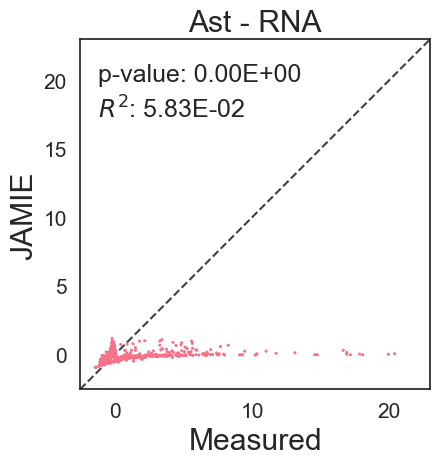

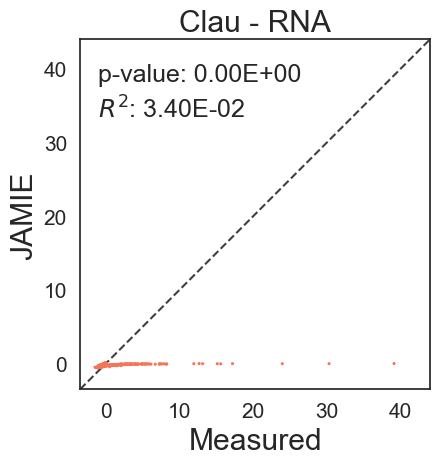

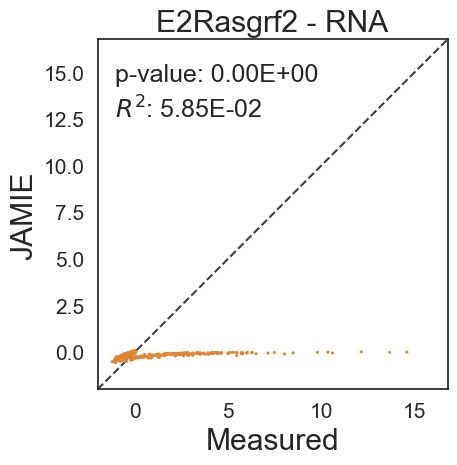

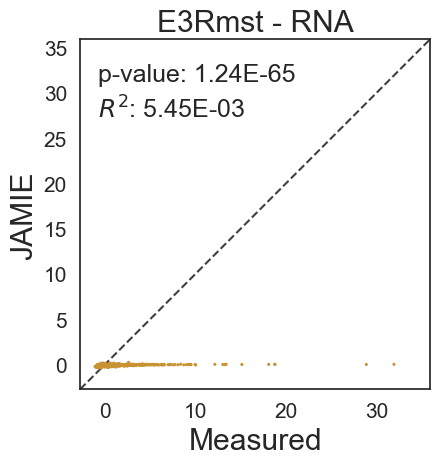

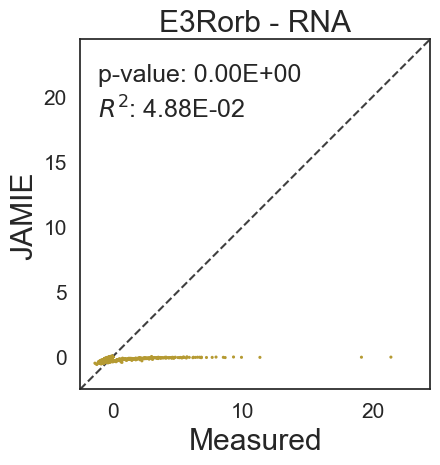

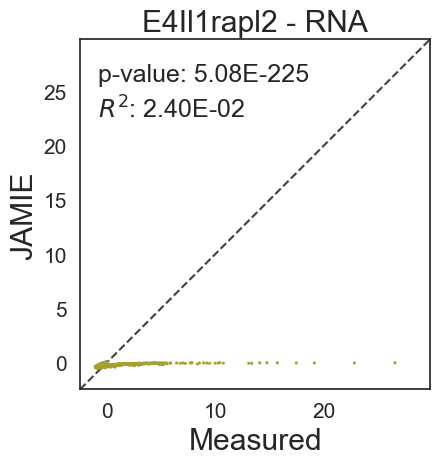

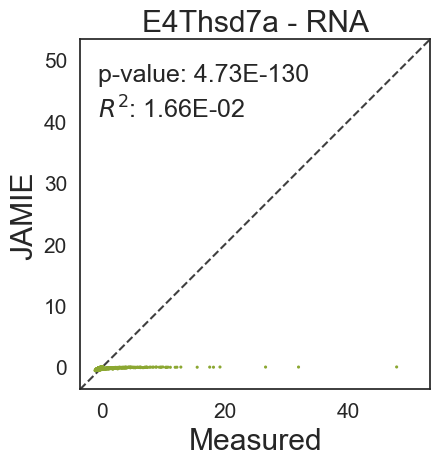

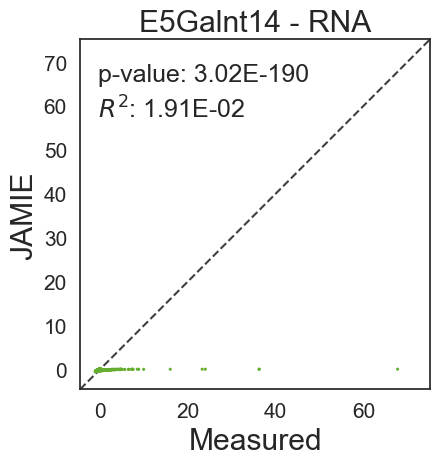

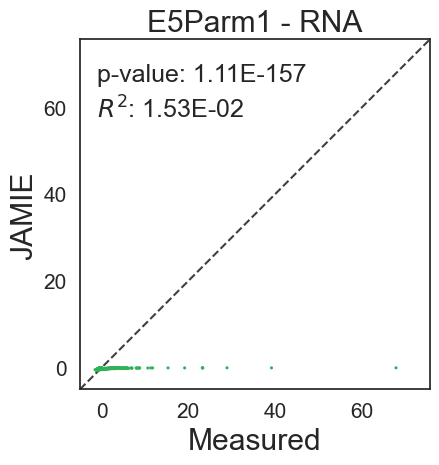

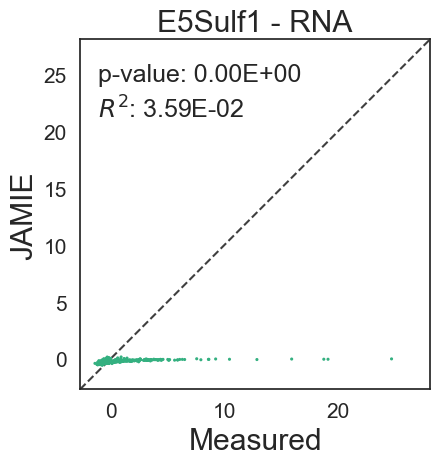

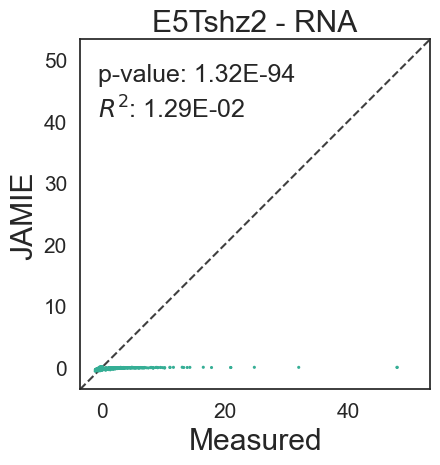

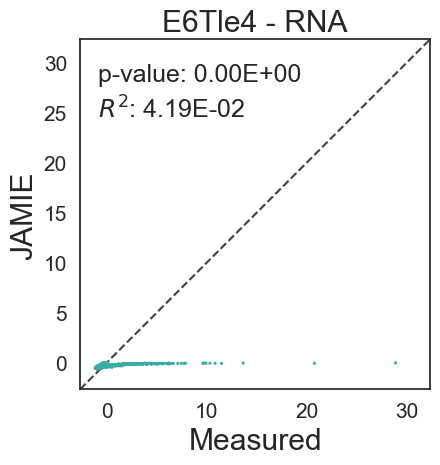

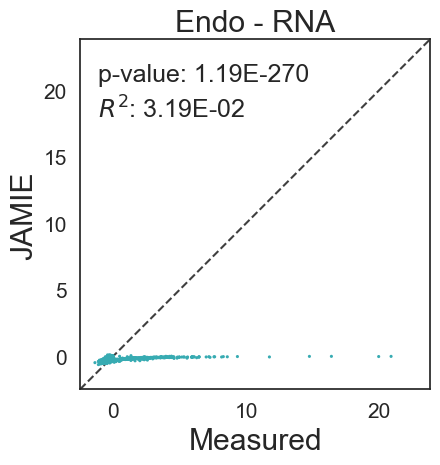

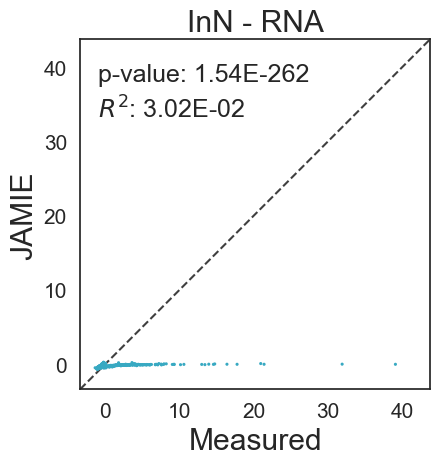

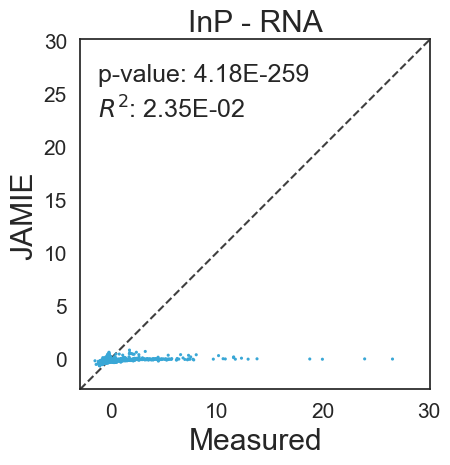

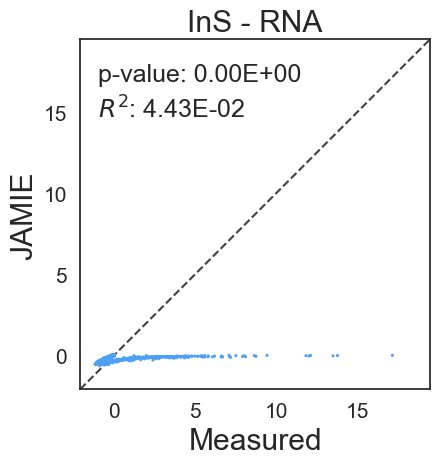

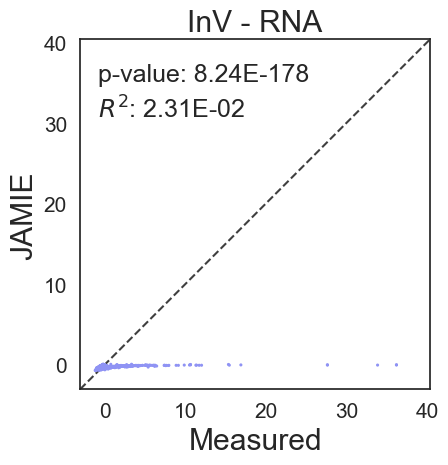

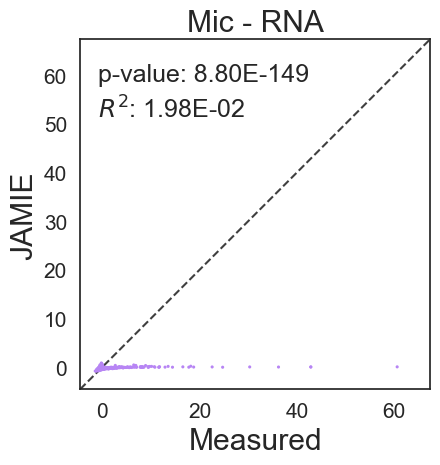

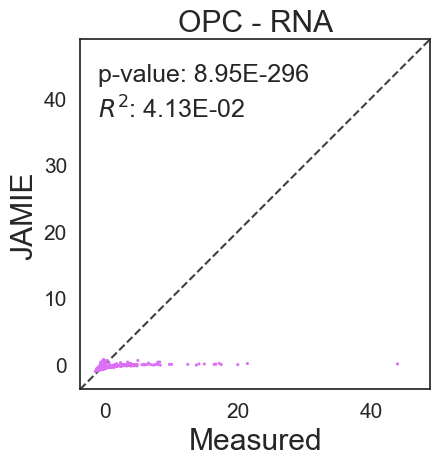

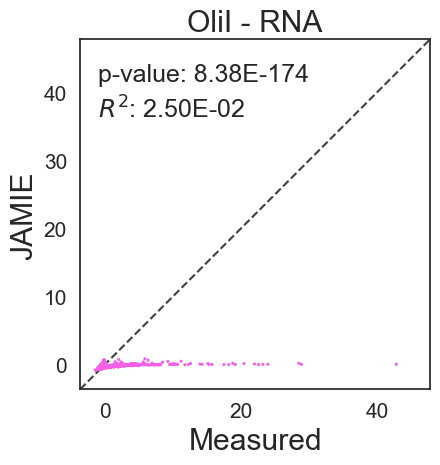

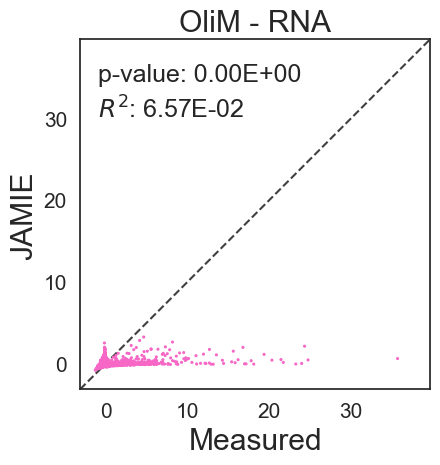

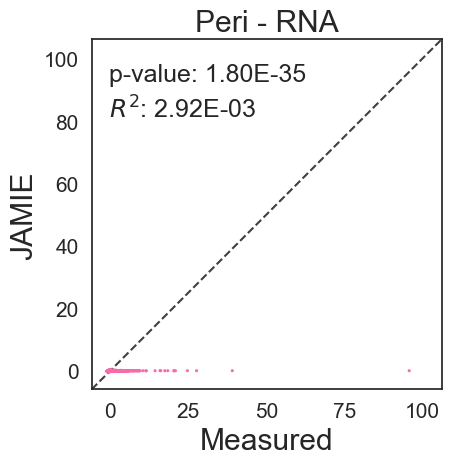

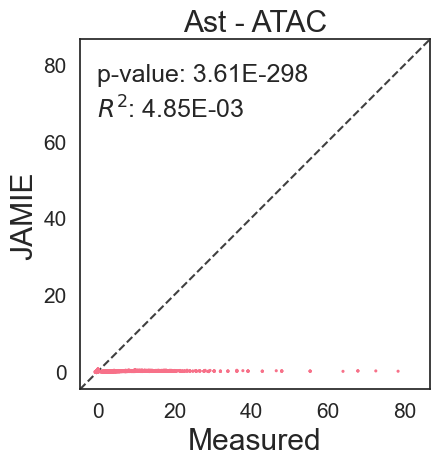

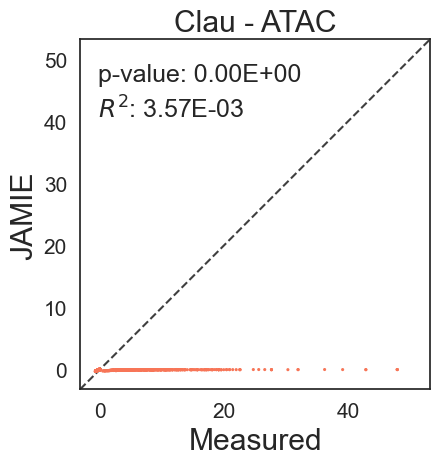

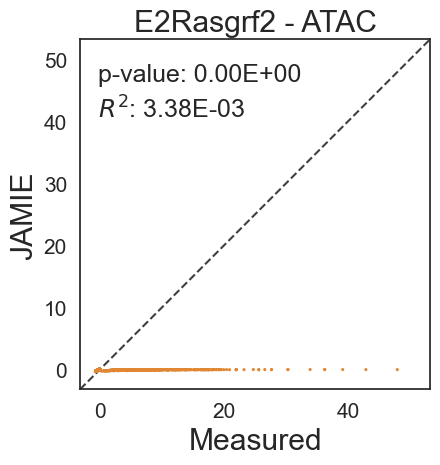

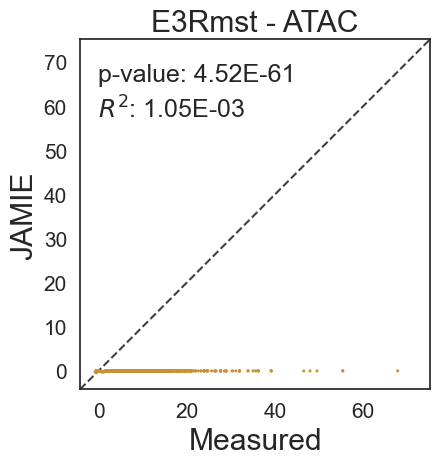

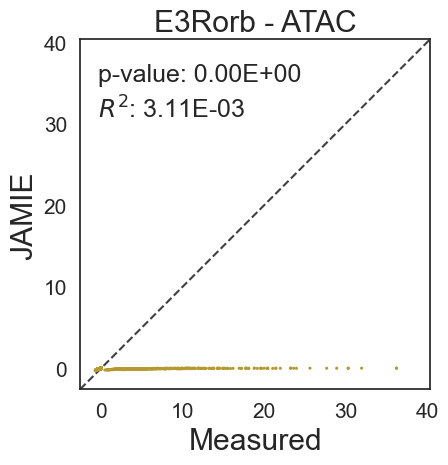

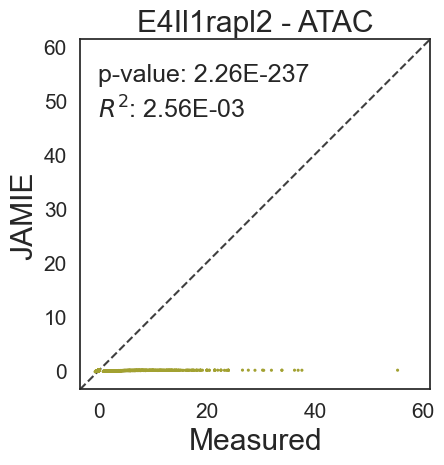

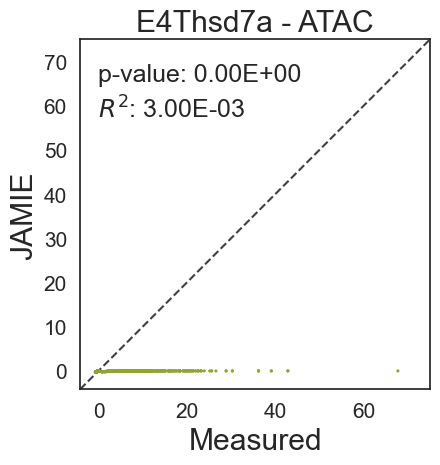

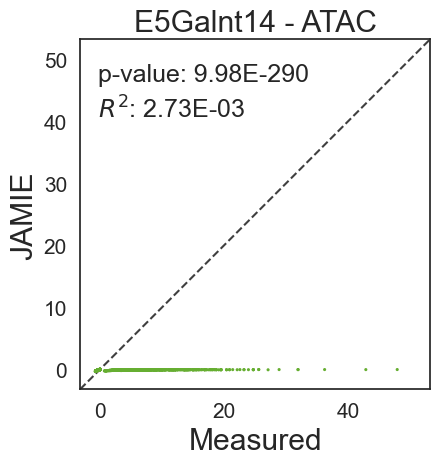

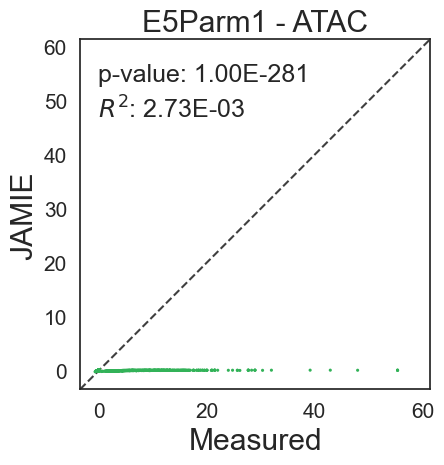

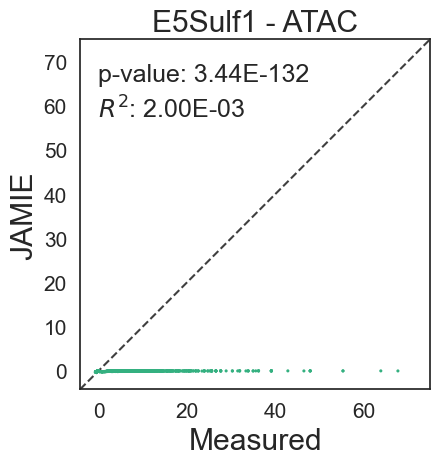

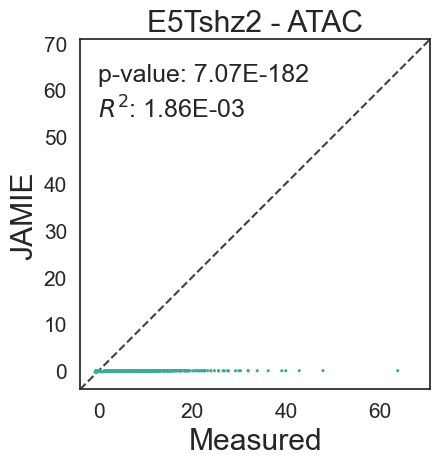

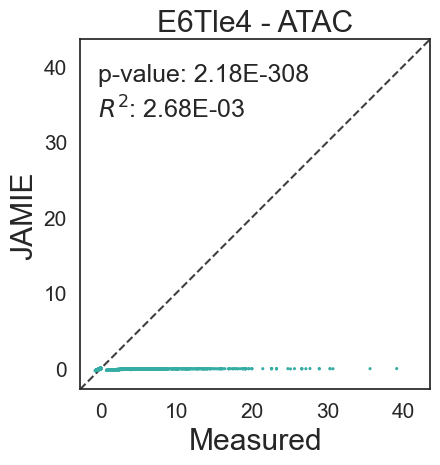

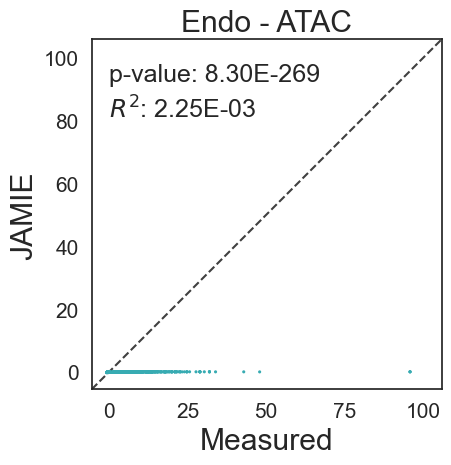

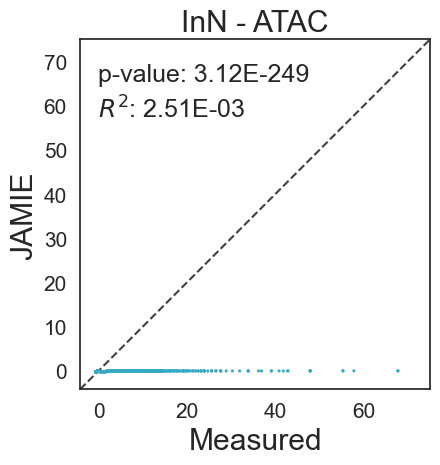

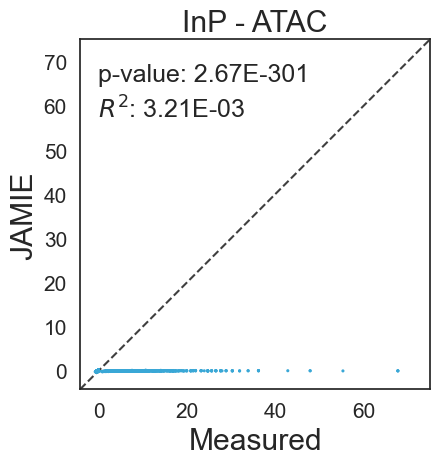

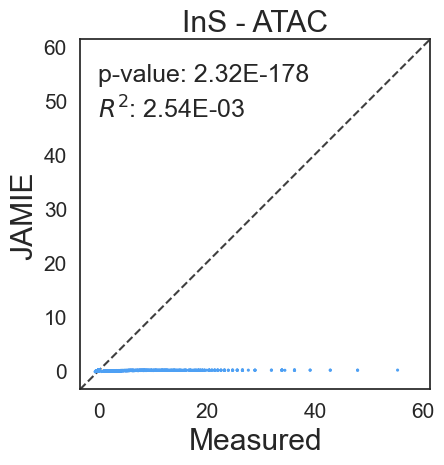

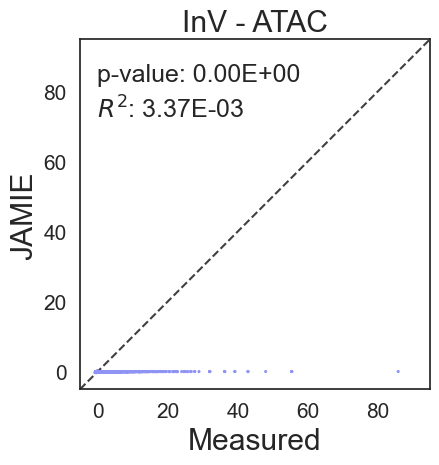

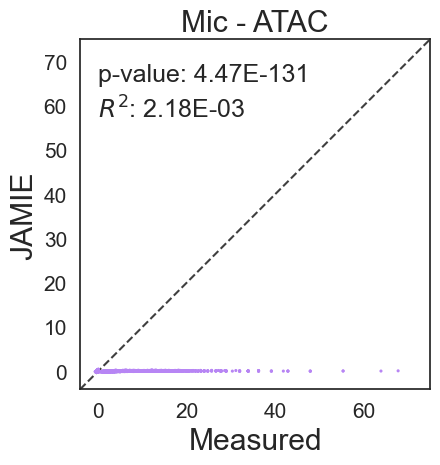

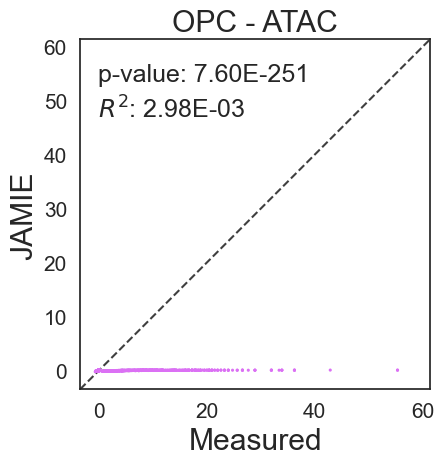

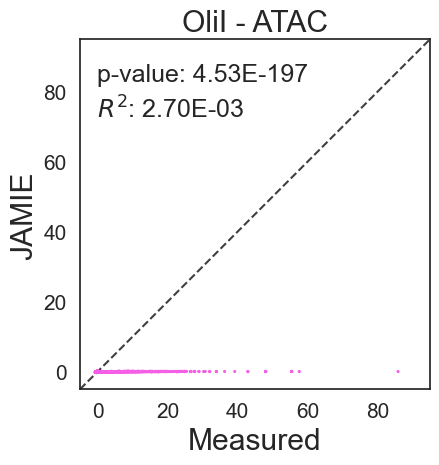

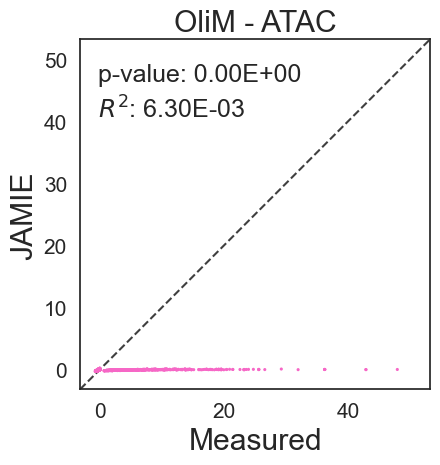

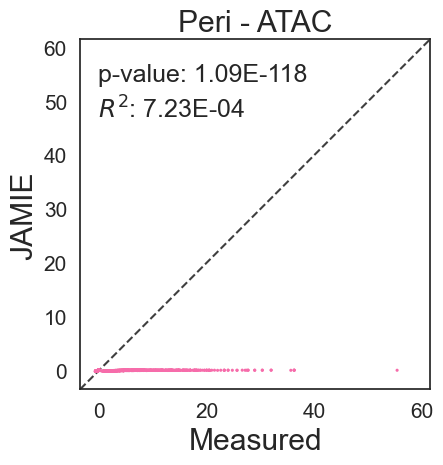

In [28]:
# Choose sample
for modality_idx in range(len(dataset)):
    for i, cell_type in enumerate(np.unique(labels[modality_idx][test_idx])):
        plt.figure(figsize=(5, 5))
        plot_sample(
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], dataset[modality_idx][test_idx]) if ct==cell_type]),
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], imputed_data[1][modality_idx]) if ct==cell_type]),
            imputed_names[1],
            modality_names[modality_idx],
            suptitle=cell_type,
            color=np.array(plt.rcParams['axes.prop_cycle'])[i]['color'])
        plt.tight_layout()
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.png', dpi=300, bbox_inches='tight')
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.svg', format='svg', bbox_inches='tight')
        plt.show()

c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Ptprd: 0.371627279479173
Malat1: 0.4556227632938044


c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


chr8:36692640-36692815: 0.8152419483873161
chr13:9011697-9011890: 0.7092256951970063


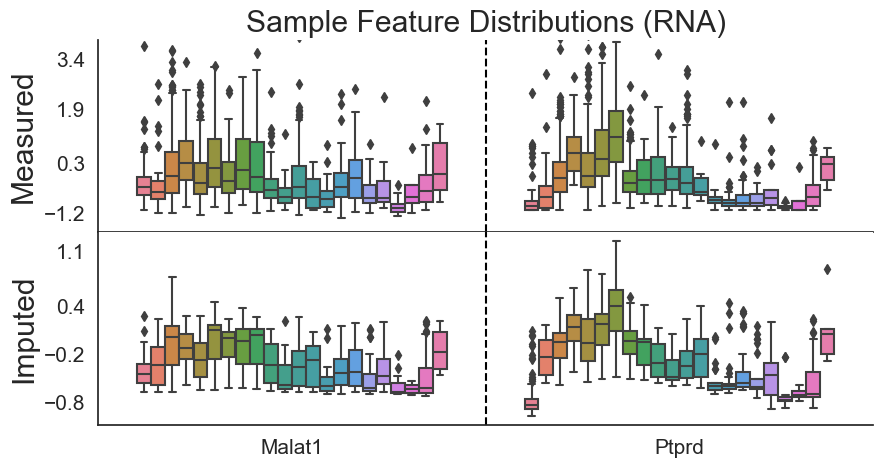

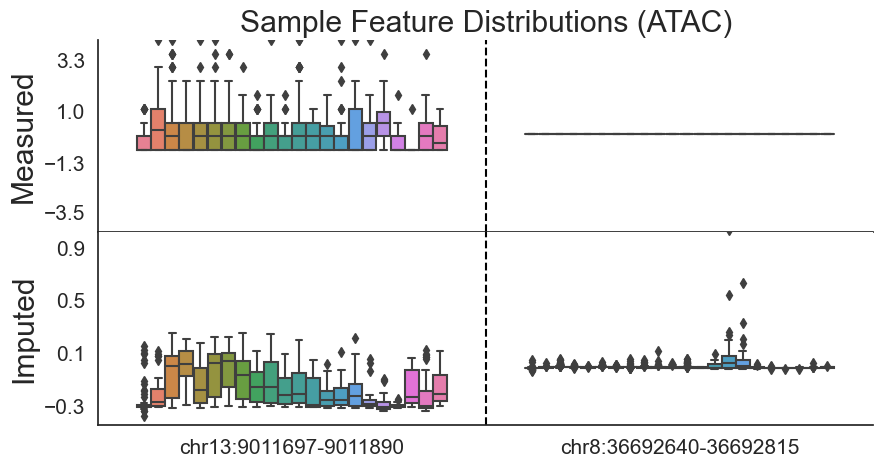

In [29]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Dist1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Dist2.svg', format='svg', bbox_inches='tight')

In [30]:
# plt.figure(figsize=(5, 5))
# plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]])
# sns.despine()
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')
# plt.savefig(image_folder + dataset_name + '-Sim1.svg', format='svg', bbox_inches='tight')

# plt.figure(figsize=(5, 5))
# plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]])
# sns.despine()
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')
# plt.savefig(image_folder + dataset_name + '-Sim2.svg', format='svg', bbox_inches='tight')